In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import datetime
import matplotlib.ticker as ticker
import pytz

## Important API Information

In [2]:
USERNAME ='OOIAPI-2VGT2I58H9V44G'
TOKEN= 'HFYV49OQEJ6'
DATA_API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

## Dive Function

In [3]:
def getNumberOfDives(depth):
    
    bottom = max(depth)
    atBottom = False
    diveCount = 0
    
    for i in range(0, len(depth)):
        
        if(depth[i]>0.95*bottom and not atBottom):
            atBottom = True
            
        if(depth[i]<0.95*bottom and atBottom):
            atBottom = False
            diveCount += 1
            
    return diveCount

## Time Function

In [4]:
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()
pst_delta = 8*3600

def ntp_seconds_to_datetime(ntp_seconds):
    timestamp = datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
    utc_timezone = pytz.timezone('UTC')
    pst_timezone = pytz.timezone('US/Pacific')
    time = utc_timezone.localize(timestamp).astimezone(pst_timezone)
    return time

## Hyperlink Builder (with saved month)

In [5]:
def hyperlinkBuilder(location,startDate,endDate,startTime,endTime):

    data_request_url = DATA_API_BASE_URL+\
                    location+\
                    'beginDT='+\
                    startDate+\
                    'T'+\
                    startTime+\
                    'Z&'+\
                    'endDT='+\
                    endDate+\
                    'T'+\
                    endTime+\
                    'Z&'+\
                    'limit=1000'
    return data_request_url, saved_month

## Decent Data to Pull From

In [79]:
#API_Request = ['https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE02SHSP/SP001/08-CTDPFJ000/recovered_cspp/ctdpf_j_cspp_instrument_recovered?beginDT=2017-08-26T19:54:46.000Z&endDT=2017-08-27T19:54:46.000Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE02SHSP/SP001/08-CTDPFJ000/recovered_cspp/ctdpf_j_cspp_instrument_recovered?beginDT=2017-10-07T19:54:46.000Z&endDT=2017-10-08T19:54:46.000Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSPS/SF01B/2A-CTDPFA107/streamed/ctdpf_sbe43_sample?beginDT=2016-07-05T19:54:41.760Z&endDT=2016-07-06T19:54:41.760Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSPS/SF01B/2A-CTDPFA107/streamed/ctdpf_sbe43_sample?beginDT=2015-12-09T19:54:41.760Z&endDT=2015-12-10T19:54:41.760Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSPD/DP01B/01-CTDPFL105/recovered_wfp/dpc_ctd_instrument_recovered?beginDT=2014-08-22T00:04:46.928Z&endDT=2014-08-23T00:04:46.928Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSPD/DP01B/01-CTDPFL105/recovered_wfp/dpc_ctd_instrument_recovered?beginDT=2015-10-29T00:04:46.928Z&endDT=2015-10-30T00:04:46.928Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS01SBPS/SF01A/2A-CTDPFA102/streamed/ctdpf_sbe43_sample?beginDT=2016-07-05T18:41:52.175Z&endDT=2016-07-06T18:41:52.175Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE02SHSP/SP001/08-CTDPFJ000/recovered_cspp/ctdpf_j_cspp_instrument_recovered?beginDT=2019-07-25T19:54:46.373Z&endDT=2019-07-26T19:54:46.373Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS01SBPD/DP01A/01-CTDPFL104/recovered_inst/dpc_ctd_instrument_recovered?beginDT=2019-07-19T17:42:10.582Z&endDT=2019-07-20T17:42:10.582Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS01SBPD/DP01A/01-CTDPFL104/recovered_wfp/dpc_ctd_instrument_recovered?beginDT=2015-10-10T00:07:00.379Z&endDT=2015-10-11T00:07:00.379Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS03AXPS/SF03A/2A-CTDPFA302/streamed/ctdpf_sbe43_sample?beginDT=2019-07-21T00:00:50.955Z&endDT=2019-07-22T00:00:50.955Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS03AXPS/SF03A/2A-CTDPFA302/streamed/ctdpf_sbe43_sample?beginDT=2019-12-21T00:00:50.955Z&endDT=2019-12-22T00:00:50.955Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS03AXPD/DP03A/01-CTDPFL304/recovered_inst/dpc_ctd_instrument_recovered?beginDT=2019-07-21T19:32:36.920Z&endDT=2019-07-22T19:32:36.920Z&limit=1000',
#              'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/RS03AXPD/DP03A/01-CTDPFL304/recovered_inst/dpc_ctd_instrument_recovered?beginDT=2019-12-21T19:32:36.920Z&endDT=2019-12-22T19:32:36.920Z&limit=1000']

## Location Names and Addresses

In [6]:
locations = ['1) Coastal Endurance Oregon Shelf Surface Piercing Profiler Mooring',
            '2) Coastal Endurance Oregon Offshore Cabled Shallow Profiler Mooring',
            '3) Coastal Endurance Oregon Offshore Cabled Deep Profiler Mooring',
            '4) Cabled Array Oregon Slope Base Shallow Profiler',
            '5) Cabled Array Oregon Slope Base Deep Profiler',
            '6) Cabled Array Axial Base Shallow Profiler',
            '7) Cabled Array Axial Base Deep Profiler']

In [7]:
sensors = ['CE02SHSP/SP001/08-CTDPFJ000/recovered_cspp/ctdpf_j_cspp_instrument_recovered?',
          'CE04OSPS/SF01B/2A-CTDPFA107/streamed/ctdpf_sbe43_sample?',
          'CE04OSPD/DP01B/01-CTDPFL105/recovered_wfp/dpc_ctd_instrument_recovered?',
          'RS01SBPS/SF01A/2A-CTDPFA102/streamed/ctdpf_sbe43_sample?',
          'RS01SBPD/DP01A/01-CTDPFL104/recovered_inst/dpc_ctd_instrument_recovered?',
          'RS03AXPS/SF03A/2A-CTDPFA302/streamed/ctdpf_sbe43_sample?',
          'RS03AXPD/DP03A/01-CTDPFL304/recovered_inst/dpc_ctd_instrument_recovered?']

## Inputs with Print Statements

In [8]:
print('Please input the number for one of the locations listed below:')
for i in range(len(locations)):
    print('\t' + locations[i])
key_input = int(input())
calling_int = key_input -1
print('You have selected: '+ locations[calling_int])
print('Please input a start and end date relative to PST')
print('Example: 2019-07-25')
startDate = input()
endDate = input()
print('Please input a start and end time in PST')
print('Example: 19:54:46.373')
startTime = input()
endTime = input()

Please input the number for one of the locations listed below:
	1) Coastal Endurance Oregon Shelf Surface Piercing Profiler Mooring
	2) Coastal Endurance Oregon Offshore Cabled Shallow Profiler Mooring
	3) Coastal Endurance Oregon Offshore Cabled Deep Profiler Mooring
	4) Cabled Array Oregon Slope Base Shallow Profiler
	5) Cabled Array Oregon Slope Base Deep Profiler
	6) Cabled Array Axial Base Shallow Profiler
	7) Cabled Array Axial Base Deep Profiler
2
You have selected: 2) Coastal Endurance Oregon Offshore Cabled Shallow Profiler Mooring
Please input a start and end date relative to PST
Example: 2019-07-25
2015-12-09
2015-12-10
Please input a start and end time in PST
Example: 19:54:46.373
19:54:41.760
19:54:41.760


## Time Transform

In [9]:
year = startDate[:4]
year=int(year)
month=startDate[5:-3]
month=int(month)
saved_month = month
day = startDate[8:]
day = int(day)
hour = startTime[:2]
hour = int(hour)
minute = startTime[3:-7]
minute = int(minute)
second = startTime[6:-4]
second = int(second)
utc_timezone = pytz.timezone("UTC")
pst_timezone = pytz.timezone("US/Pacific")
time = pst_timezone.localize(datetime.datetime(year, month, day, hour, minute, second)).astimezone(utc_timezone)
time = str(time)
startDate = time[:10]
startTime = time[11:-6]+startTime[-4:]
year = endDate[:4]
year=int(year)
month=endDate[5:-3]
month=int(month)
day = endDate[8:]
day = int(day)
hour = endTime[:2]
hour = int(hour)
minute = endTime[3:-7]
minute = int(minute)
second = endTime[6:-4]
second = int(second)
utc_timezone = pytz.timezone("UTC")
pst_timezone = pytz.timezone("US/Pacific")
time = pst_timezone.localize(datetime.datetime(year, month, day, hour, minute, second)).astimezone(utc_timezone)
time = str(time)
endDate = time[:10]
endTime = time[11:-6]+startTime[-4:]

## API Request

In [11]:
#apiPull holds the link first, and then the saved month second
apiPull = []
apiPull = hyperlinkBuilder(sensors[calling_int],startDate,endDate,startTime,endTime)
r = requests.get(apiPull[0], auth=(USERNAME, TOKEN))
imported_data = r.json()
data = pd.DataFrame(imported_data)

## Pulling Variables

In [12]:
header = data.columns
titles = []

for i in range(len(header)):
    if header[i] == 'seawater_temperature':
        titles.append(header[i])
    elif header[i] == 'temp':
        titles.append(header[i])
    elif header[i] == 'temperature':
        titles.append(header[i])
    elif header[i] == 'seawater_pressure':
        titles.append(header[i])
    elif header[i] == 'pressure':
        titles.append(header[i])
    elif header[i] == 'salinity':
        titles.append(header[i])
    elif header[i] == 'practical_salinity':
        titles.append(header[i])
    elif header[i] == 'time':
        titles.append(header[i])

location_time = []
location_temp = []
location_pressure = []
location_salinity = []
        
for i in range(len(titles)):
    if titles[i] == 'time':
        location_time.append(i)
    elif titles[i] == 'temp' or titles[i] == 'temperature' or  titles[i] == 'seawater_temperature':
        location_temp.append(i)
    elif titles[i] == 'seawater_pressure' or titles[i] == 'pressure':
        location_pressure.append(i)
    elif titles[i] == 'salinity' or titles[i] == 'practical_salinity':
        location_salinity.append(i)

In [13]:
time = []
temperature = []
pressure = []
salinity = []

countTemp = 0
countPressure = 0
countSalinity = 0

for i in range(len(data)):
    time.append(ntp_seconds_to_datetime(data[titles[location_time[0]]][i]))
    
    temperature.append(data[titles[location_temp[countTemp]]][i])
    if temperature[i] > 36:
        countTemp += 1
        temperature[i] = data[titles[location_temp[countTemp]]][i]
        
    pressure.append(data[titles[location_pressure[countPressure]]][i])
    if pressure[i] > 10994:
        countPressure += 1
        pressure[i] = data[titles[location_pressure[countPressure]]][i]
    
    salinity.append(data[titles[location_salinity[countSalinity]]][i])
    if salinity[i] > 50:
        countSalinity += 1
        salinity[i] = data[titles[location_salinity[countSalinity]]][i]
        
ssp = [0 for x in range(len(temperature))]
for k in range(len(temperature)):
    ssp[k] = 1449.2+(4.6*temperature[k])-(.055*temperature[k]*temperature[k])+(.00029*temperature[k]*temperature[k]*temperature[k])+((1.34-(0.01*temperature[k]))*(salinity[k]-35))+(0.016*pressure[k])

## Plots and Arrays for Plots

In [14]:
plot_title = ['Coastal Endurance Oregon Shelf Surface Piercing Profiler Mooring',
            'Coastal Endurance Oregon Offshore Cabled Shallow Profiler Mooring',
            'Coastal Endurance Oregon Offshore Cabled Deep Profiler Mooring',
            'Cabled Array Oregon Slope Base Shallow Profiler',
            'Cabled Array Oregon Slope Base Deep Profiler',
            'Cabled Array Axial Base Shallow Profiler',
            'Cabled Array Axial Base Deep Profiler']

In [17]:
def season(input_month):
    if 3 < month <10:
        season = 'Summer'
    else:
        season = 'Winter'
    return season

Dive Count:
9


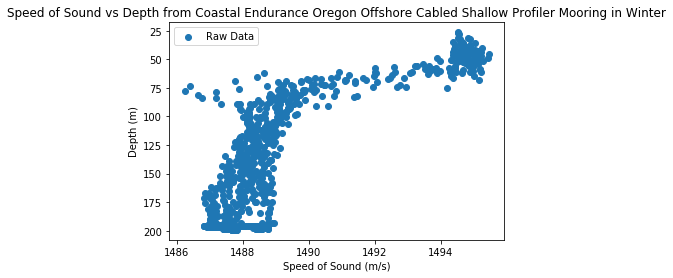

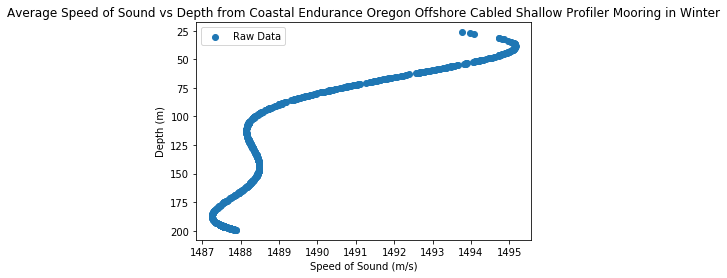

Residuals from error:
[560.09383008]


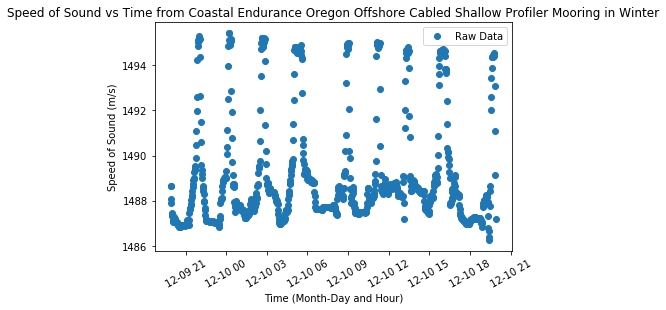

In [50]:
dives = getNumberOfDives(pressure)
print('Dive Count:')
print(dives)

SvW = season(apiPull[1])

plt.scatter(ssp,pressure)
plt.gca().invert_yaxis()
plt.legend(['Raw Data'])
plt.title('Speed of Sound vs Depth from ' + plot_title[calling_int] + ' in ' + SvW)
plt.ylabel('Depth (m)')
plt.xlabel('Speed of Sound (m/s)')
plt.show()
poly = np.polyfit(pressure,ssp,5,full=True)
poly_ssp = np.poly1d(poly[0])(pressure)
plt.scatter(poly_ssp,pressure)
plt.gca().invert_yaxis()
plt.legend(['Raw Data'])
plt.title('Average Speed of Sound vs Depth from ' + plot_title[calling_int] + ' in ' + SvW)
plt.ylabel('Depth (m)')
plt.xlabel('Speed of Sound (m/s)')
plt.show()
print('Residuals from error:')
print(poly[1])
plt.plot_date(time,ssp)
plt.xticks(rotation=30)
plt.tight_layout()
plt.legend(['Raw Data'])
plt.title('Speed of Sound vs Time from ' + plot_title[calling_int] + ' in ' + SvW)
plt.xlabel('Time (Month-Day and Hour)')
plt.ylabel('Speed of Sound (m/s)')
plt.show()